In [8]:
# Loads gaze-related metrics for each trial and participant and performs statistical analysis for the whole study 

In [60]:
import re
import matplotlib.pyplot as plt
from enum import Enum
import os
import statistics
import numpy as np
import get_tcm as tcm
import helpers as hl

import csv
import pandas as pd

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

from statsmodels.stats.anova import AnovaRM

from scipy.stats import sem, t, ttest_rel, shapiro, wilcoxon, mannwhitneyu

import seaborn as sns

In [3]:
data_dir="Z:/builds/aplause-mr/UNITY_APP/aplause-mr-20240707-studystate-v1/gazeAnalysis"

file_path = data_dir + "/gaze_classification_analysis_results.csv"

df = pd.read_csv(file_path)
df

,participant_id,trial,group,condition,audio_condition,avatar_condition,gaze_local_pc,gaze_remote_adjacent_pc,gaze_remote_opposite_pc,gaze_others_pc,...,glance_remote_opposite_per_min,mutual_gaze_local_pc,mutual_gaze_local_mean_duration,mutual_gaze_local_per_min,mutual_gaze_remote_opp_pc,mutual_gaze_remote_opp_mean_duration,mutual_gaze_remote_opp_per_min,mutual_gaze_remote_adj_pc,mutual_gaze_remote_adj_mean_duration,mutual_gaze_remote_adj_per_min
0,0,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,18.387516,12.327698,55.786736,86.501951,...,12.795839,2.600780,1.111111,1.404421,37.295189,1.541935,14.512354,4.005202,0.855556,2.808843
1,1,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,5.331599,22.288687,39.817945,67.438231,...,11.235371,2.600780,1.111111,1.404421,12.145644,0.676812,10.767230,2.782835,0.972727,1.716515
2,2,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,3.172952,14.668401,58.179454,76.020806,...,10.299090,1.014304,0.780000,0.780234,37.295189,1.541935,14.512354,2.782835,0.972727,1.716515
3,3,0,0,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC,13.888166,30.195059,33.211964,77.295189,...,15.136541,1.014304,0.780000,0.780234,12.145644,0.676812,10.767230,4.005202,0.855556,2.808843
4,0,1,0,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,17.973062,5.012144,66.173548,89.158755,...,9.406050,0.419519,0.475000,0.529918,40.759550,1.619298,15.102672,1.368956,0.885714,0.927357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,3,2,19,SPATIAL_VOLUMETRIC,SPATIAL,VOLUMETRIC,8.477041,19.925203,40.556825,68.959069,...,17.826719,0.000000,-1.000000,0.000000,21.961355,0.794737,16.580096,2.888012,0.695000,2.493247
252,0,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,28.726356,6.027743,22.723834,57.477932,...,8.776797,7.717528,0.927273,4.993695,4.590164,0.791304,3.480454,1.488020,0.536364,1.664565
253,1,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,24.262295,3.051702,46.506936,73.820933,...,18.612863,7.717528,0.927273,4.993695,16.973518,0.701042,14.527112,0.151324,0.600000,0.151324
254,2,3,19,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,2.118537,5.346784,18.486759,25.952081,...,11.803279,0.075662,0.150000,0.302648,4.590164,0.791304,3.480454,0.151324,0.600000,0.151324


In [56]:
# outlier / missing data detection

# Select numerical and text columns
numerical_cols = df.select_dtypes(include='number').columns.drop(['trial', 'participant_id', 'group'])
text_cols = ['condition', 'audio_condition', 'avatar_condition']

negative_rows = df[df[numerical_cols].lt(0).any(axis=1)]
negative_rows



,participant_id,trial,group,condition,audio_condition,avatar_condition,gaze_local_pc,gaze_remote_adjacent_pc,gaze_remote_opposite_pc,gaze_others_pc,...,glance_remote_opposite_per_min,mutual_gaze_local_pc,mutual_gaze_local_mean_duration,mutual_gaze_local_per_min,mutual_gaze_remote_opp_pc,mutual_gaze_remote_opp_mean_duration,mutual_gaze_remote_opp_per_min,mutual_gaze_remote_adj_pc,mutual_gaze_remote_adj_mean_duration,mutual_gaze_remote_adj_per_min
36,0,1,2,SPATIAL_ABSTRACT,SPATIAL,ABSTRACT,10.066329,2.926258,42.684354,55.676941,...,15.216543,0.000000,-1.000000,0.000000,3.277409,0.600000,3.277409,0.507218,1.300000,0.234101
37,1,1,2,SPATIAL_ABSTRACT,SPATIAL,ABSTRACT,1.950839,27.155677,31.642606,60.749122,...,11.236832,0.000000,-1.000000,0.000000,24.346469,1.273469,11.470933,4.330862,0.740000,3.511510
40,0,2,2,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,5.732123,0.510783,51.049943,57.292849,...,16.004540,0.000000,-1.000000,0.000000,3.093076,0.726667,2.553916,0.000000,-1.000000,0.000000
41,1,2,2,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,0.425653,32.604994,22.956867,55.987514,...,8.683314,0.000000,-1.000000,0.000000,19.920545,1.462500,8.172531,1.759364,0.442857,2.383655
43,3,2,2,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT,17.026107,1.333712,71.935301,90.295119,...,6.640182,0.766175,0.675000,0.681044,19.920545,1.462500,8.172531,0.000000,-1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,3,2,16,SPATIAL_ABSTRACT,SPATIAL,ABSTRACT,10.396040,18.637158,34.449621,63.482819,...,6.988934,2.184042,0.833333,1.572510,22.218987,1.338596,9.959231,0.000000,-1.000000,0.000000
242,2,0,19,SPATIAL_ABSTRACT,SPATIAL,ABSTRACT,3.116559,8.456264,18.553916,30.126740,...,11.718263,0.000000,-1.000000,0.000000,5.402036,0.666667,4.861833,0.353210,0.425000,0.498649
243,3,0,19,SPATIAL_ABSTRACT,SPATIAL,ABSTRACT,8.560150,13.567422,47.080823,69.208394,...,20.569292,0.000000,-1.000000,0.000000,31.830459,1.014570,18.824018,0.041554,0.100000,0.249325
250,2,2,19,SPATIAL_VOLUMETRIC,SPATIAL,VOLUMETRIC,1.786827,10.887181,20.299190,32.973198,...,9.723665,0.000000,-1.000000,0.000000,5.879909,0.764865,4.612508,1.205070,0.644444,1.121961


In [178]:
# Create dataset that averages numeric data from each trial



# specify that numeric cols should be averaged (apart from frequency cols which should be added) 
# and non-numeric should just take first value 
agg_dict = {col: 'mean' for col in numerical_cols}  
agg_dict.update({col: 'sum' for col in numerical_cols if "per_min" in col})
agg_dict.update({col: 'first' for col in text_cols})

averaged_trial_df = df.groupby(['trial', 'group']).agg(agg_dict).reset_index()


# metrics relating to mutual gaze appear twice within each trial. For proportion and gaze duration metrics, this
# is not a problem, since doubling up results and then averaging makes no difference.
# However, frequency results, which are summed should be divided by 2 to maintain correctness.
columns_to_divide = [c for c in numerical_cols if "per_min" in c and "mutual" in c]
averaged_trial_df[columns_to_divide] = averaged_trial_df[columns_to_divide] / 2

# no summing when calculating row-for-group dataset - just averaging across trials
agg_dict_grouped = {col: 'mean' for col in numerical_cols}  
agg_dict_grouped.update({col: 'first' for col in text_cols})

averaged_group_df = averaged_trial_df.groupby(['group']).agg(agg_dict_grouped).reset_index()
averaged_group_df



,group,gaze_local_pc,gaze_remote_adjacent_pc,gaze_remote_opposite_pc,gaze_others_pc,gaze_transition_pc,gaze_avert_pc,pc_all,gaze_transition_mean_duration_sec,gaze_glance_mean_duration_sec,...,mutual_gaze_local_per_min,mutual_gaze_remote_opp_pc,mutual_gaze_remote_opp_mean_duration,mutual_gaze_remote_opp_per_min,mutual_gaze_remote_adj_pc,mutual_gaze_remote_adj_mean_duration,mutual_gaze_remote_adj_per_min,condition,audio_condition,avatar_condition
0,0,11.432882,16.767480,47.607749,75.808111,7.141472,16.540253,99.489836,0.349309,2.229302,...,3.002175,24.274261,1.098707,25.528513,2.801429,0.837474,3.692371,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC
1,1,16.228974,15.687043,33.505191,65.421208,11.067315,23.094059,99.582581,0.324338,1.720014,...,3.755402,11.034689,0.706799,18.130468,2.555481,0.667101,3.785436,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT
2,2,7.959666,13.030000,38.085268,59.074933,8.726455,31.196526,98.997913,0.327835,2.252547,...,0.774900,12.038690,1.011695,12.841884,2.081629,0.290812,3.516121,SPATIAL_VOLUMETRIC,SPATIAL,VOLUMETRIC
3,3,11.410856,11.875128,39.755955,63.041939,9.195410,27.650406,99.887755,0.299960,1.835889,...,4.047474,13.356578,0.715779,20.130949,1.206656,0.286193,2.011180,SPATIAL_ABSTRACT,SPATIAL,ABSTRACT
4,4,7.188233,22.646545,38.857401,68.692179,9.976551,20.965040,99.633770,0.331427,2.255215,...,0.416419,15.239976,0.972169,19.753196,6.435649,0.948200,8.495612,DIOTIC_VOLUMETRIC,DIOTIC,VOLUMETRIC
5,5,6.190988,11.026292,46.835020,64.052300,12.802441,22.993254,99.847995,0.344866,1.789521,...,1.567009,24.044208,0.903802,31.743624,0.717629,0.175298,1.353025,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT
6,6,13.834046,11.643655,45.596131,71.073832,9.953435,18.681888,99.709156,0.325342,1.857856,...,4.239397,19.939647,0.911063,26.242834,0.899420,0.581944,1.851609,SPATIAL_VOLUMETRIC,SPATIAL,VOLUMETRIC
7,9,7.009123,6.078895,45.922420,59.010438,4.939069,35.485155,99.434661,0.289720,2.289724,...,0.764692,14.521491,1.044257,16.903902,0.078880,-0.468750,0.226515,DIOTIC_ABSTRACT,DIOTIC,ABSTRACT
8,10,8.318489,16.426862,33.404588,58.149940,12.182355,29.178269,99.510564,0.345676,1.445688,...,2.218287,9.962851,0.644399,17.492324,3.525882,0.647494,6.777191,SPATIAL_VOLUMETRIC,SPATIAL,VOLUMETRIC
9,11,10.864600,16.217348,38.354483,65.436431,7.866434,26.253203,99.556068,0.348947,2.070692,...,2.924238,12.061777,1.009007,14.882645,3.066748,0.746156,4.753244,SPATIAL_ABSTRACT,SPATIAL,ABSTRACT


In [163]:
# Some libraries to use for ANOVA...

# to get started: effect of conditions on gaze_local_pc?
# check differences in mean by condition
pd.DataFrame(round(averaged_trial_df.groupby(['audio_condition'])['gaze_local_pc'].mean(),2)).reset_index()
# pd.DataFrame(round(averaged_trial_df.groupby(['avatar_condition'])['gaze_local_pc'].mean(),2)).reset_index()
# pd.DataFrame(round(averaged_trial_df.groupby(['avatar_condition', 'audio_condition'])['gaze_local_pc'].mean(),2)).reset_index()

# between correct?
# model2 = pg.anova(dv='gaze_local_pc', between=['avatar_condition', 'audio_condition'], data=averaged_trial_df, detailed=True)
# round(model2, 4)

# Fit the model using OLS
# model = ols('gaze_local_pc ~ C(audio_condition) * C(avatar_condition)', data=averaged_trial_df).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

,audio_condition,gaze_local_pc
0,DIOTIC,10.53
1,SPATIAL,9.89


In [164]:
def RunAnova(variable):
    anova_rm = AnovaRM(data=averaged_trial_df, depvar=variable, subject='group', within=['audio_condition', 'avatar_condition'])
    res = anova_rm.fit()

    # check for normal distribution
    nres = shapiro(averaged_trial_df[variable])

    print('Variable: ' + variable)
    print('Normality is assumed' if nres.pvalue>0.05 else 'Not normally distributed')
    print(res.anova_table)
    print('\n')


In [165]:
non_mutual_numeric_cols = numerical_cols.drop([c for c in numerical_cols if "mutual" in c])

for col in non_mutual_numeric_cols:
    RunAnova(col)


Variable: gaze_local_pc
Normality is assumed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   4.851113     1.0    15.0  0.043685
avatar_condition                  1.742889     1.0    15.0  0.206565
audio_condition:avatar_condition  3.977253     1.0    15.0  0.064623


Variable: gaze_remote_adjacent_pc
Normality is assumed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.604154     1.0    15.0  0.449083
avatar_condition                  36.519041     1.0    15.0  0.000023
audio_condition:avatar_condition   0.977902     1.0    15.0  0.338402


Variable: gaze_remote_opposite_pc
Normality is assumed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   0.017109     1.0    15.0  0.897671
avatar_condition                  4.189596     1.0    15.0  0.058611
audio_condition:avatar_condition  0.001061     1.0    15.0  0.974439


Variabl

In [166]:
def boxplot_all(bp_df, variable_names, filename=None, ncols=3):
    x='condition'
    order=None
    sharey=True
    showmeans = True
    rotate_xlabel=True
    nrows = int(np.ceil(len(variable_names)/ncols))
    figsize=(ncols*6,nrows*9)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=sharey)
    if len(variable_names)>1:
        axes = axes.flatten()
    if rotate_xlabel:
        for ax in axes:
            ax.tick_params(axis='x', rotation=20)
    
    for i,v in enumerate(variable_names):
#         if palette is not None:
#             _ = sns.boxplot(hue=x, y=q, data=df, width=0.5, order=order, ax=axes[i], showmeans=showmeans, palette=palette,
#                             meanprops={"marker": ".", "markeredgecolor": "black","markersize": "10", 'markerfacecolor':'white'})
#         else:
        _ = sns.boxplot(x=x, y=v, data=bp_df, width=0.5, order=order, ax=axes[i], showmeans=showmeans,
                        meanprops={"marker": ".", "markeredgecolor": "black","markersize": "10", 'markerfacecolor':'white'})
#     adjust_box_widths(fig, fac)
    
    if filename is not None:
        fig.savefig(filename)
    
    return axes


In [167]:

pc_cols = [c for c in non_mutual_numeric_cols if "pc" in c and c != "pc_all"]
duration_cols = [c for c in non_mutual_numeric_cols if "sec" in c]
freq_cols = [c for c in non_mutual_numeric_cols if "per_min" in c]

print(pc_cols)
print(duration_cols)
print(freq_cols)


['gaze_local_pc', 'gaze_remote_adjacent_pc', 'gaze_remote_opposite_pc', 'gaze_others_pc', 'gaze_transition_pc', 'gaze_avert_pc']
['gaze_transition_mean_duration_sec', 'gaze_glance_mean_duration_sec']
['glance_per_min', 'glance_local_per_min', 'glance_remote_adjacent_per_min', 'glance_remote_opposite_per_min']


C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

PermissionError: [Errno 13] Permission denied: 'pc_boxplots.pdf'

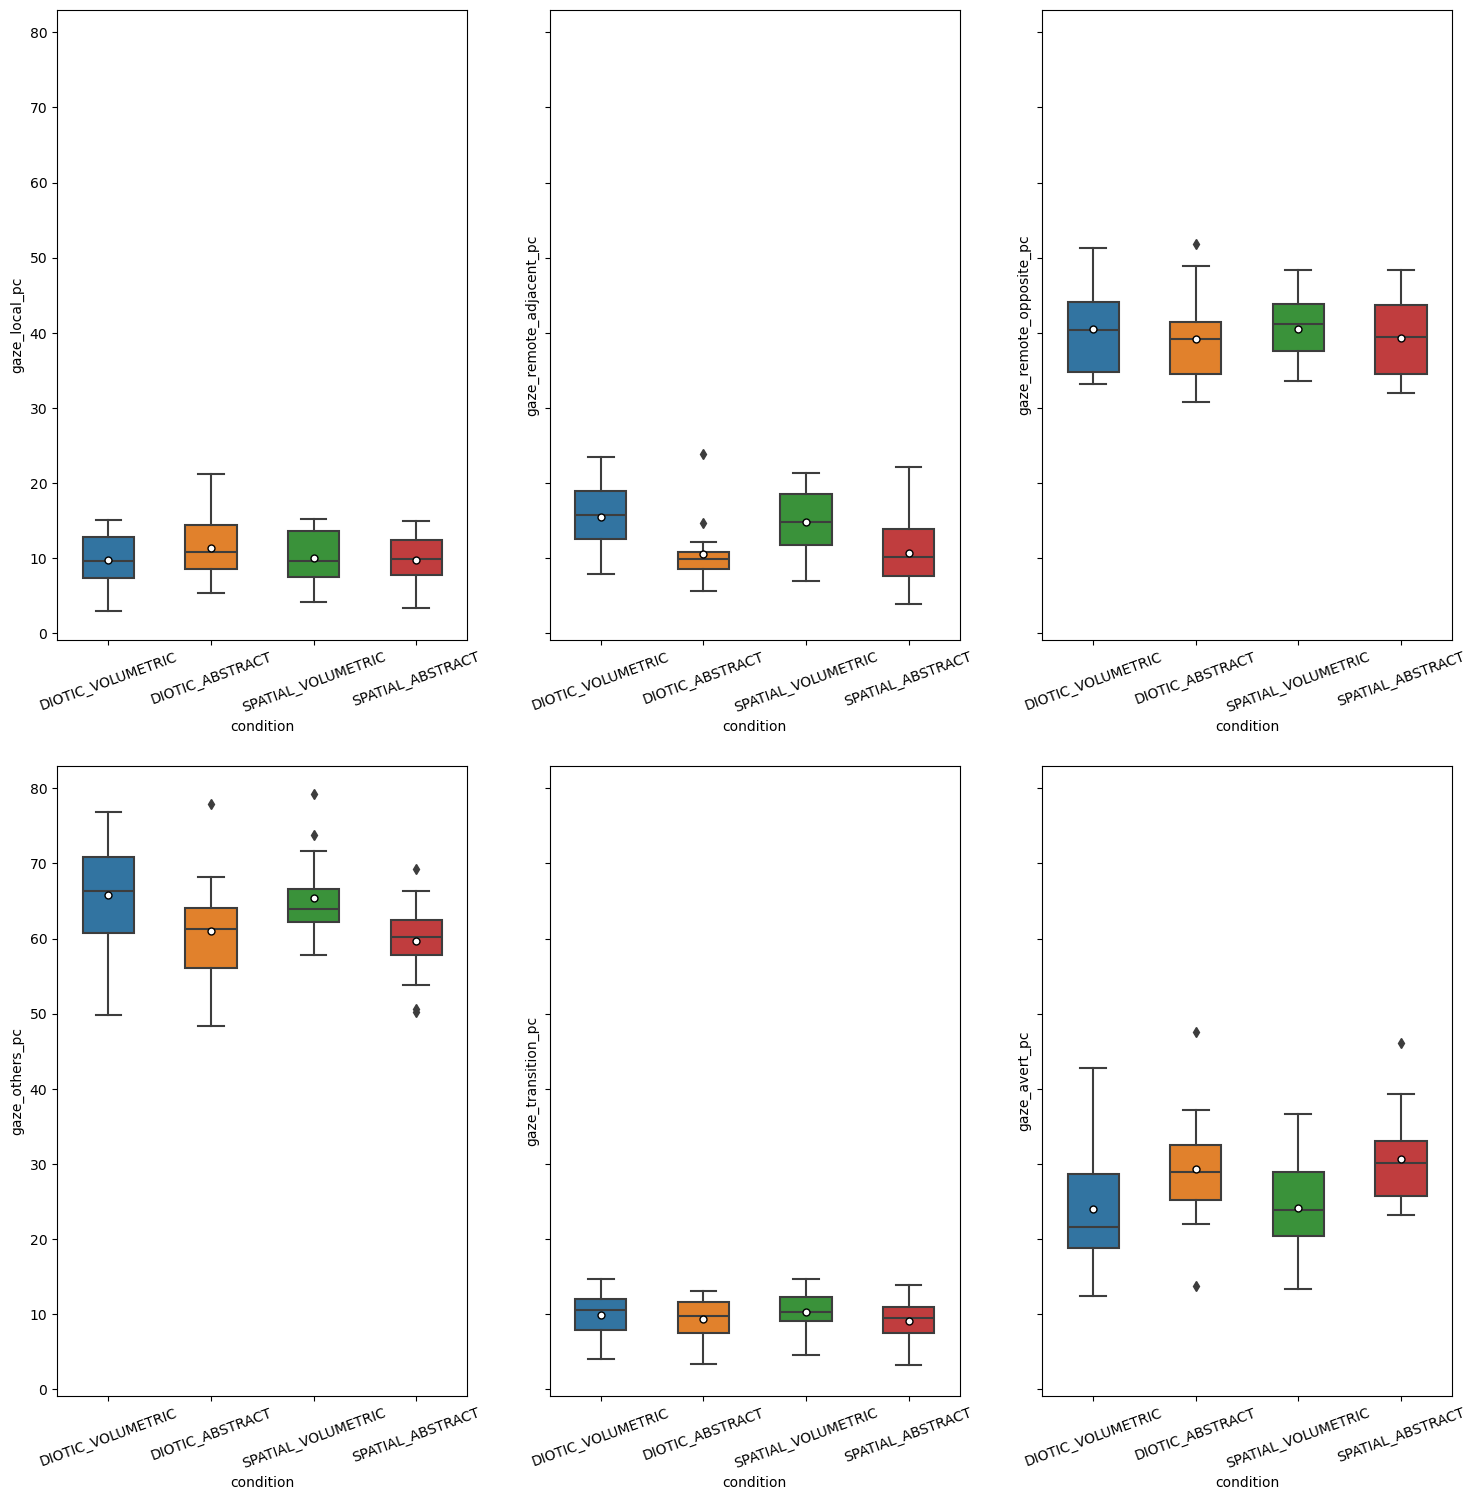

In [168]:
bp = boxplot_all(averaged_trial_df, pc_cols, "pc_boxplots.pdf")

In [ ]:
bp = boxplot_all(averaged_trial_df, duration_cols, "duration_boxplots.pdf", ncols=2)

C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

PermissionError: [Errno 13] Permission denied: 'freq_boxplots.pdf'

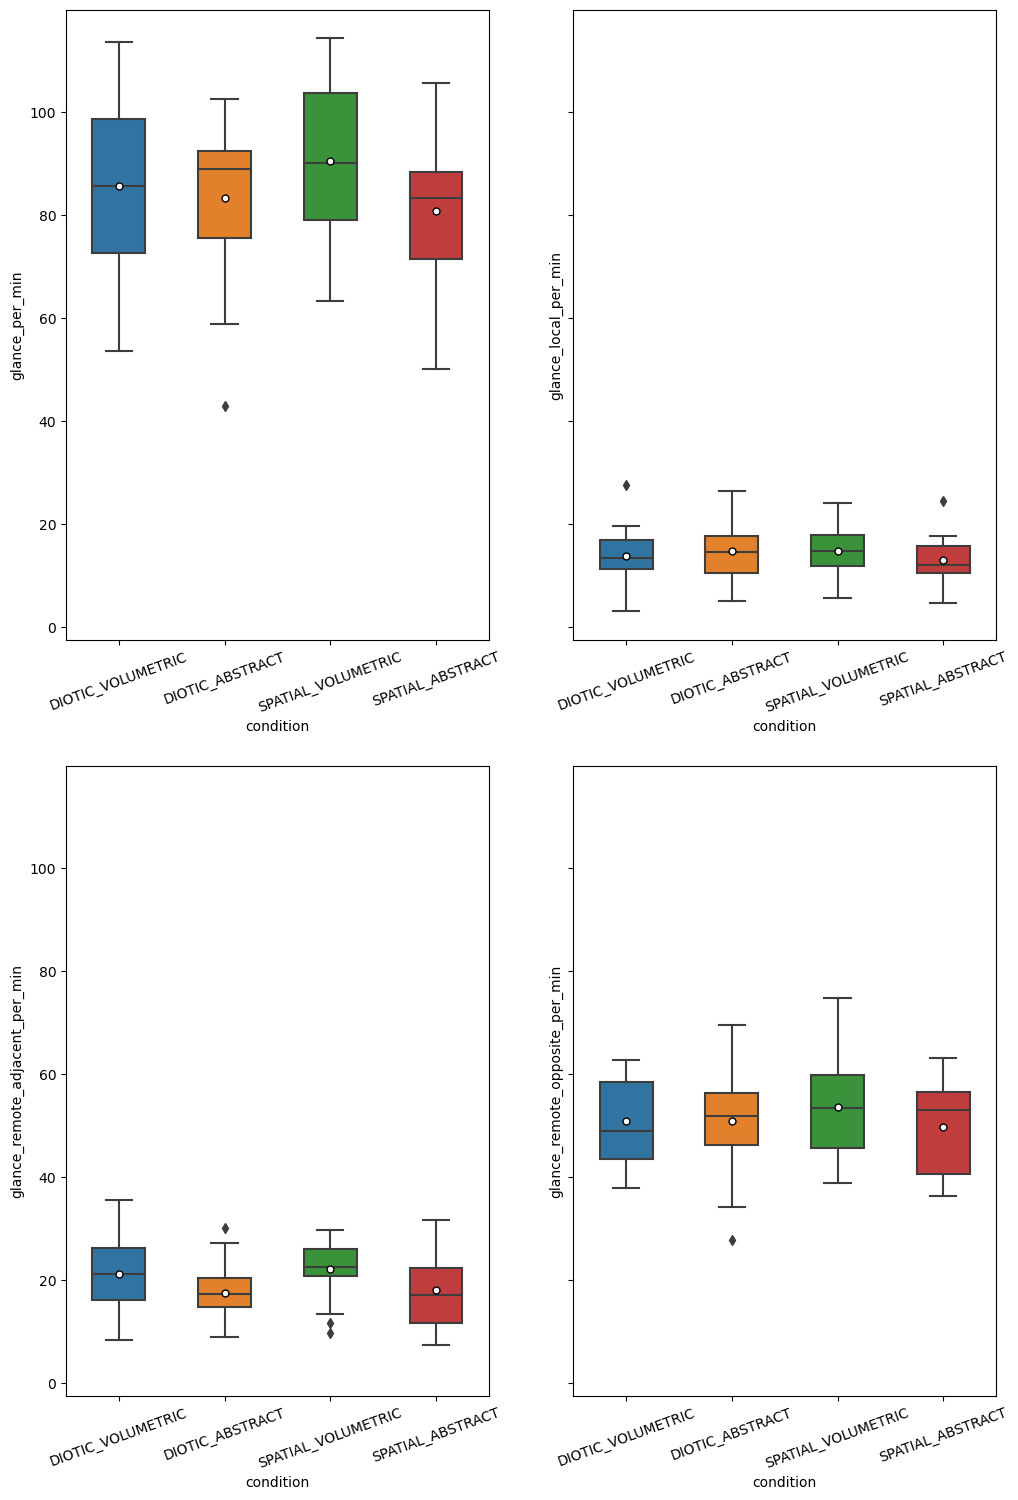

In [169]:
bp = boxplot_all(averaged_trial_df, freq_cols, "freq_boxplots.pdf", ncols=2)

# Gaze Classification

Comparing gaze metrics for local and collocated users


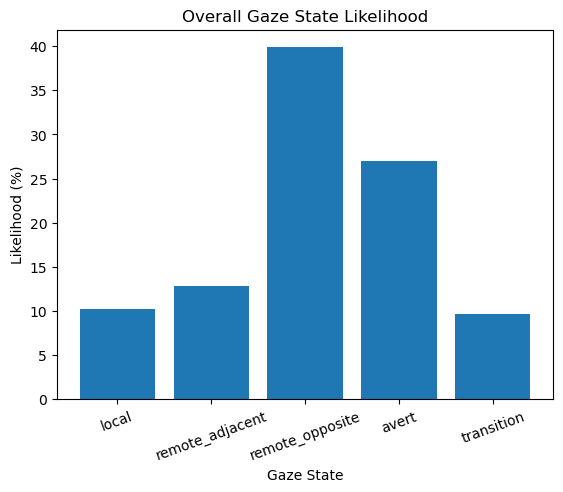

In [181]:
# compare proportion of time spent in each gaze state
cols = ['gaze_local_pc', 'gaze_remote_adjacent_pc', 'gaze_remote_opposite_pc', 'gaze_avert_pc', 'gaze_transition_pc']

labels = [c.replace('_pc','').replace('gaze_','') for c in cols]
plt.bar(labels, averaged_group_df[cols].mean())
plt.ylabel('Likelihood (%)')
plt.xlabel('Gaze State')
plt.title('Overall Gaze State Likelihood')
plt.xticks(labels, rotation=20)
plt.show()


In [191]:
# Is difference between remote_adjacent and local significant?

t_statistic, p_value = ttest_rel(averaged_group_df['gaze_local_pc'], averaged_group_df['gaze_remote_adjacent_pc'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


T-statistic: -1.9219471054613855
P-value: 0.07381757814826546


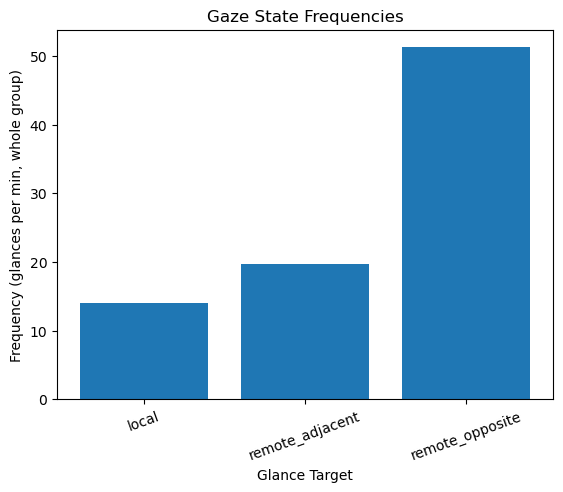

In [184]:
# compare frequency of glances at each target
cols = ['glance_local_per_min', 'glance_remote_adjacent_per_min', 'glance_remote_opposite_per_min']

labels = [c.replace('_per_min','').replace('glance_','') for c in cols]
plt.bar(labels, averaged_group_df[cols].mean())
plt.ylabel('Frequency (glances per min, whole group)')
plt.xlabel('Glance Target')
plt.title('Gaze State Frequencies')
plt.xticks(labels, rotation=20)
plt.show()

In [185]:
# Is difference between remote_adjacent and local significant?

t_statistic, p_value = ttest_rel(averaged_group_df['glance_local_per_min'], averaged_group_df['glance_remote_adjacent_per_min'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -3.1543526971604647
P-value: 0.006547805623984581


# Mutual Gaze Analysis

How do experimental conditions affect mutual gaze?

In [186]:
mutual_numeric_cols = numerical_cols.drop([c for c in numerical_cols if "mutual" not in c])

mutual_pc_cols = [c for c in mutual_numeric_cols if "pc" in c and c != "pc_all"]
mutual_duration_cols = [c for c in mutual_numeric_cols if "duration" in c]
mutual_freq_cols = [c for c in mutual_numeric_cols if "per_min" in c]

print(mutual_pc_cols)
print(mutual_duration_cols)
print(mutual_freq_cols)



# for col in non_mutual_numeric_cols:
#     RunAnova(col)


['mutual_gaze_local_pc', 'mutual_gaze_remote_opp_pc', 'mutual_gaze_remote_adj_pc']
['mutual_gaze_local_mean_duration', 'mutual_gaze_remote_opp_mean_duration', 'mutual_gaze_remote_adj_mean_duration']
['mutual_gaze_local_per_min', 'mutual_gaze_remote_opp_per_min', 'mutual_gaze_remote_adj_per_min']


C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

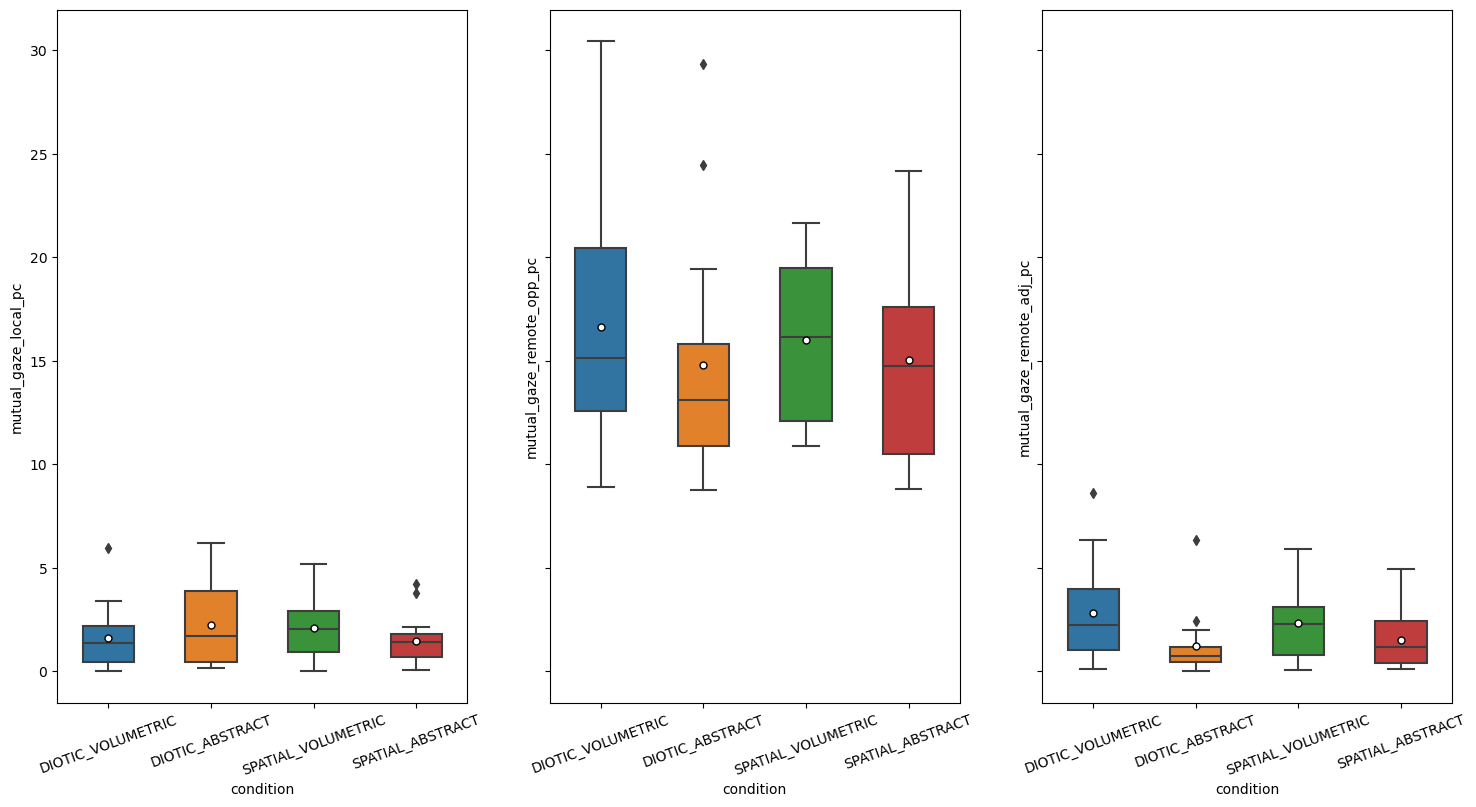

In [188]:
bp = boxplot_all(averaged_trial_df, mutual_pc_cols, "mutual_pc_boxplots.pdf")

In [189]:
# TODO how to deal with negative values for duration here?

# bp = boxplot_all(averaged_trial_df, mutual_duration_cols, "mutual_duration_boxplots.pdf")

C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gary4\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

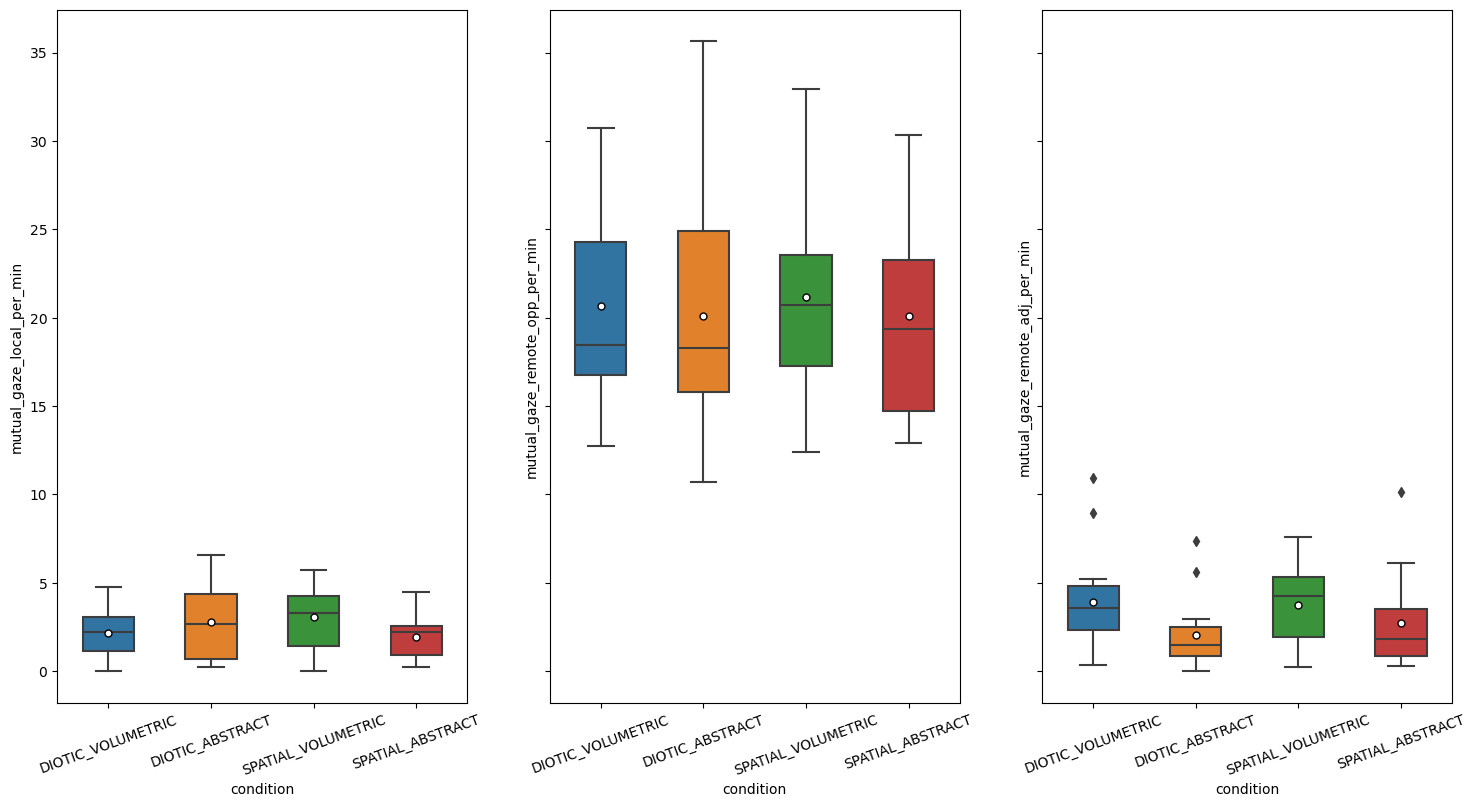

In [190]:
bp = boxplot_all(averaged_trial_df, mutual_freq_cols, "mutual_freq_boxplots.pdf")

In [192]:
for col in mutual_pc_cols:
    RunAnova(col)


Variable: mutual_gaze_local_pc
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.416601     1.0    15.0  0.528388
avatar_condition                   0.002083     1.0    15.0  0.964196
audio_condition:avatar_condition  10.118778     1.0    15.0  0.006200


Variable: mutual_gaze_remote_opp_pc
Not normally distributed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   0.030940     1.0    15.0  0.862728
avatar_condition                  4.503337     1.0    15.0  0.050890
audio_condition:avatar_condition  0.419747     1.0    15.0  0.526856


Variable: mutual_gaze_remote_adj_pc
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.163553     1.0    15.0  0.691614
avatar_condition                  19.388241     1.0    15.0  0.000514
audio_condition:avatar_condition   5.085318     1.0 

In [ ]:
# for col in mutual_duration_cols:
#     RunAnova(col)

In [193]:
for col in mutual_freq_cols:
    RunAnova(col)


Variable: mutual_gaze_local_per_min
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.002810     1.0    15.0  0.958425
avatar_condition                   1.227149     1.0    15.0  0.285410
audio_condition:avatar_condition  13.458908     1.0    15.0  0.002281


Variable: mutual_gaze_remote_opp_per_min
Normality is assumed
                                   F Value  Num DF  Den DF    Pr > F
audio_condition                   0.111393     1.0    15.0  0.743183
avatar_condition                  1.063595     1.0    15.0  0.318740
audio_condition:avatar_condition  0.057375     1.0    15.0  0.813936


Variable: mutual_gaze_remote_adj_per_min
Not normally distributed
                                    F Value  Num DF  Den DF    Pr > F
audio_condition                    0.660679     1.0    15.0  0.429033
avatar_condition                  17.858070     1.0    15.0  0.000734
audio_condition:avatar_condition   2.5346

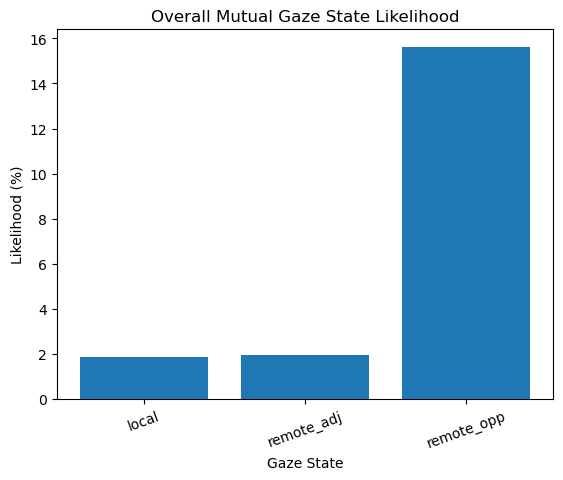

In [195]:
# compare proportion of time spent in each gaze state
cols = ['mutual_gaze_local_pc', 'mutual_gaze_remote_adj_pc', 'mutual_gaze_remote_opp_pc']

labels = [c.replace('_pc','').replace('mutual_gaze_','') for c in cols]
plt.bar(labels, averaged_group_df[cols].mean())
plt.ylabel('Likelihood (%)')
plt.xlabel('Gaze State')
plt.title('Overall Mutual Gaze State Likelihood')
plt.xticks(labels, rotation=20)
plt.show()

In [196]:
# Is difference between remote_adjacent and local significant?

t_statistic, p_value = ttest_rel(averaged_group_df['mutual_gaze_local_pc'], averaged_group_df['mutual_gaze_remote_adj_pc'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: -0.16051848422874573
P-value: 0.874614443659202


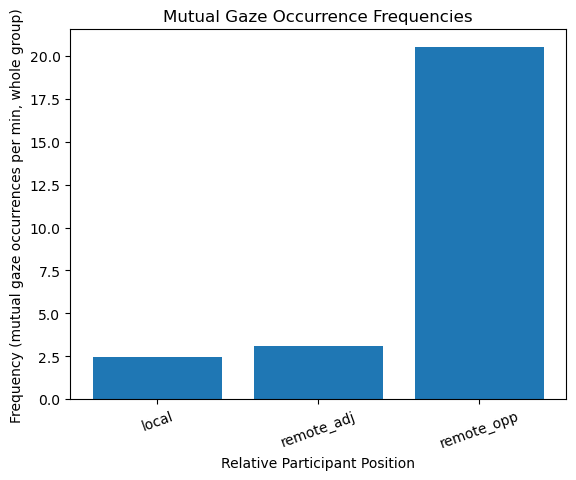

In [197]:
# compare frequency of glances at each target
cols = ['mutual_gaze_local_per_min', 'mutual_gaze_remote_adj_per_min', 'mutual_gaze_remote_opp_per_min']

labels = [c.replace('_per_min','').replace('mutual_gaze_','') for c in cols]
plt.bar(labels, averaged_group_df[cols].mean())
plt.ylabel('Frequency (mutual gaze occurrences per min, whole group)')
plt.xlabel('Relative Participant Position')
plt.title('Mutual Gaze Occurrence Frequencies')
plt.xticks(labels, rotation=20)
plt.show()

In [199]:
# Is difference between remote_adjacent and local significant?

t_statistic, p_value = ttest_rel(averaged_group_df['mutual_gaze_local_per_min'], averaged_group_df['mutual_gaze_remote_adj_per_min'])

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


T-statistic: -0.8584066232354334
P-value: 0.40417664971763556


0     3.002175
1     3.755402
2     0.774900
3     4.047474
4     0.416419
5     1.567009
6     4.239397
7     0.764692
8     2.218287
9     2.924238
10    0.210700
11    3.925554
12    3.746723
13    2.206308
14    1.245987
15    4.638036
Name: mutual_gaze_local_per_min, dtype: float64